In [188]:
# Setup if running in colab
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  try:
    if runonce:
      print("Already ran")
  
  except:
    runonce = True
    !pip install wandb
    !git clone https://github.com/Jimmy-Nnilsson/StudieGrupp3_MLProjekt.git
    
    import wandb
    wandb.login()

In [189]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [190]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
print("TF: ", tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
from keras import Model
import keras

from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras.applications import vgg16, vgg19, mobilenet_v2, inception_v3
from sklearn.metrics import confusion_matrix, classification_report

import wandb
from wandb.keras import WandbCallback

import cv2

TF:  2.7.0


In [191]:
def seed_everything():
    # os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    random.seed(1254)
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

seed_everything()

In [192]:
# Get base project directory
if not RunningInCOLAB:
#   project_path = Path(os.getcwd()).parent.parent

  for i, p in enumerate(Path(os.getcwd()).parts):
    if p == "StudieGrupp3_MLProjekt":
        break
    pathparts = list(Path(os.getcwd()).parts[0:i+2])
    project_path = Path(pathparts[0],"\\\\".join(pathparts[1:]))
else:
  project_path = Path('/content/StudieGrupp3_MLProjekt/')
datapath = (project_path /'data/processed/')

CLASSES = {0 : 'yes', 1 : 'no'}
# Loops through pathlist and reads and resizes images
def read_image(pathlist : list, size : int)-> list:
    data = []
    for path in pathlist:
        image=load_img(path, color_mode='rgb', target_size=(size, size))
        # image=load_img(path, color_mode='rgb', target_size=(size, size))
        image=img_to_array(image)
        # image=image/255.0
        data.append(image)
    data = np.asarray(data, dtype=np.uint8)
    return data

# Makes input and label data from folder locations.
# Loops through location "subfolder/CLASSES"
def get_sets(subfolder : str, CLASSES : dict, size : int):
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"2_split_{v}/{subfolder}").rglob("*"))
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    folder_labels = np.asarray(folder_labels, dtype=np.uint8)
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

def get_training_set(CLASSES : dict, size : int):
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        # folder_paths += list((datapath / f"3_aug_{v}_train/").rglob("*"))
        # folder_paths += list((datapath / f"3_augmentation_train/3_aug_geo_{v}_train/").rglob("*"))
        folder_paths += list((datapath / f"3_augmentation_train/3_aug_pix_{v}_train/").rglob("*"))
        # print(folder_paths)
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

Load Pictures

In [193]:
# Dataset inspect
# Read images to variables
size = 224
X_aug_train, y_aug_train = get_training_set(CLASSES, size)
X_train, y_train = get_sets('train', CLASSES, size)
X_val, y_val = get_sets('val', CLASSES, size)
X_test, y_test = get_sets('test', CLASSES, size)

Data loader

In [194]:
#@title
@tf.function
def preprocess(image: tf.Tensor, label: tf.Tensor):
    """
    Preprocess the image tensors and parse the labels
    """
    # Preprocess images
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Parse label
    label = tf.cast(label, tf.float32)

    return image, label


def prepare_dataloader(images: np.ndarray,
                       labels: np.ndarray,
                       loader_type: str='train',
                       batch_size: int=128):
    """
    Utility function to prepare dataloader.
    """
    images = model_preprocess(images)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if loader_type=='train':
        dataset = dataset.shuffle(1024)

    dataloader = (
        dataset
        .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader

def model_preprocess(images):
    images = vgg19.preprocess_input(images)
    # images = vgg16.preprocess_input(images)
    # images = mobilenet_v2.preprocess_input(images)
    # images = inception_v3.preprocess_input(images)
    
    return images

Config parameters

In [195]:
# Mind model processing
# Finetune not complete
configs = dict(
    project_name = "MRI_Baseline_3", #Project Name
    mode = 'disabled', #{'offline', 'run', 'disabled', 'dryrun', 'online'} # WandB run status
    job_type = "", #Run type for WandB
    group = "", # Group in WandB
    sub_group = "_pipeline",

    class_names = CLASSES, # Classes for training
    training_set = "",

    image_width = X_train[0].shape[0], # Picture width for model input
    image_height = X_train[0].shape[1], # Picture height for model input
    image_channels = X_train[0].shape[2], # Picture channels for model input

    pretrain_weights = 'imagenet', # pretrained weights for basemodel if any
    batch_size = 4, # Batchsize for training
    init_learning_rate = 0.001, # Initial training rate if no callback is used
    lr_decay_rate = 0.1, #decayrate of training rate
    epochs = 50, # Epochs to train
    optimizer = 'rmsprop', # The optimizer used by the ml model
    loss_fn = 'binary_crossentropy', # Loss function
    metrics = ['accuracy'], # Metrics
    earlystopping_patience = 5, # For the early stopping callback

    dataset = "Brain_MRI_Images_for_Brain_Tumor_Detection",
    fine_tune_learning_rate = 1e-5, # learningrate Used during fine tuning
    fine_tune_epochs = 10, # Epochs ran at finetuning

    architecture = "",# To be defined f"{base_model._name.upper()} global_average_pooling2d",
    model_name = '' # set after model is defined # Name of the ml Model

)

In [196]:
trainloader = prepare_dataloader(X_train, y_train, 'train', configs.get('batch_size', 64))
augtrainloader = prepare_dataloader(X_aug_train, y_aug_train, 'train', configs.get('batch_size', 64))
validloader = prepare_dataloader(X_val, y_val, 'valid', configs.get('batch_size', 64))
testloader = prepare_dataloader(X_test, y_test, 'test', configs.get('batch_size', 64))

In [197]:
configs['training_set'] = augtrainloader

Model class definition

In [198]:
class Model_Class():
    def __init__(self,
                 output_activation: str='sigmoid'
                 ):

        self.shape = (configs['image_width'],configs['image_height'], configs['image_channels'])
        self.model = ""
        # self.base_model = ""
        self.output_activation = output_activation
        self.run = ""
        self.get_model()
        self.conv_layers, self.layer_names = self.__get_convlayers()
        self.preds = ""
        if not wandb.run is None: wandb.finish()

    def get_model(self):
        tf.keras.backend.clear_session()
        kwarg = dict(weights=configs['pretrain_weights'], include_top=False, input_shape=self.shape)
        self.base_model = vgg19.VGG19(**kwarg)
        # self.base_model = vgg16.VGG16(**kwarg)
        # self.base_model = mobilenet_v2.MobileNetV2(**kwarg)
        # self.base_model = inception_v3.InceptionV3(**kwarg)
        
        self.base_model.trainable = False

        x = layers.GlobalAveragePooling2D()(self.base_model.output)
        # x = layers.Flatten()(self.base_model.output)

        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(32, activation='relu')(x)
        outputs = layers.Dense(1, activation=self.output_activation)(x)
        configs['group'] = f'{self.base_model._name}{configs["sub_group"]}'
        configs['architecture'] = self.base_model._name
        self.model  = models.Model(self.base_model.input, outputs, name=f'Baseline_{self.base_model._name.upper()}')

    def transfer_learning(self,
        callbacks: list,
        verbose: int=0,
        wb: bool=False): # Makes training run on all but base model

        train_config = {
            "learning_rate" : configs['init_learning_rate'],
            "epochs" : configs['epochs'],
            "compile" : True}
        configs['job_type'] = "Transfer learning"

        self.base_model.trainable = False
        self.__train(callbacks=callbacks, verbose=verbose, wb=wb, train_config=train_config)

    def fine_tune(self,
        callbacks: list,
        verbose: int=0,
        wb: bool=False,
        trainable_layers: list=0):

        train_config = {
            "learning_rate" : configs['fine_tune_learning_rate'],
            "epochs" : configs['fine_tune_epochs'],
            'job_type' : 'Fine-tune',
            "compile" : False}
        configs['job_type'] = "Fine-tune"
        self.set_trainable(trainable_layers)
        self.__train(callbacks=callbacks, verbose=verbose, wb=wb, train_config=train_config)

    def __train(self,
        callbacks: list,
        verbose: int=0,
        wb: bool=False,
        train_config:dict={}
        ):

        if wb:
            callbacks.append(self.__wandb())

        # Initalize model
        # tf.keras.backend.clear_session()
        configs['model_name'] = self.model._name # set

        # Compile the model
        if train_config['compile']:
          opt = tf.keras.optimizers.RMSprop(learning_rate=train_config['learning_rate'])
          self.model.compile(optimizer=opt,
                      loss=configs['loss_fn'],
                      metrics=configs['metrics'])
        
        # Train model
        _ = self.model.fit(configs['training_set'],
                    epochs=train_config['epochs'],
                    validation_data=validloader,
                    callbacks=callbacks,
                    verbose=verbose)
        if wb:
            # Evaluate the trained model
            loss, acc = self.model.evaluate(validloader)
            self.run.log({'evaluate/accuracy': acc})


            # Close the W&B run.
            self.run.finish()

    def grad_cam(self, image, layer=None):
        self.preds = self.predict(image)

        if type(layer) is list:
            heatmap_list, superimposed_list = {},{}
            for layer_num in layer:
                heatmap = self.make_gradcam_heatmap(np.expand_dims(image, axis=0), layer_num, np.argmax(self.preds[0]))
                superimposed_img = self.superimpose(image,heatmap)
                heatmap_list[self.model.layers[layer_num]._name] = heatmap
                superimposed_list[self.model.layers[layer_num]._name] = superimposed_img
            return image, heatmap_list, superimposed_list
        else:
            heatmap = self.make_gradcam_heatmap(np.expand_dims(image, axis=0), layer, np.argmax(self.preds[0]))
            superimposed_img = self.superimpose(image,heatmap)
            return image, heatmap, superimposed_img


    def make_gradcam_heatmap(self, img_array, layer=None, pred_index=None):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        if layer == None: layer=self.conv_layers[-1]
        model = self.model
        grad_model = Model(
            [model.inputs], [model.layers[layer].output, model.output]
            # [model.inputs], [model.get_layer(self.layer_names[-1]).output, model.output]
        )

        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    def predict(self, pic):
        x = model_preprocess(pic)
        if len(x.shape) < 4:
          x = np.expand_dims(x, axis=0)
        
        preds = self.model.predict(x)
        return preds

    def superimpose(self, pic,heatmap):
        img_numpy = np.asarray(np.clip(pic, 0, 190))

        heatmap_resized = cv2.resize(heatmap, (img_numpy.shape[1], img_numpy.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        superimposed_img = 0.3*heatmap_resized[:,:,::-1] + img_numpy
        superimposed_img = superimposed_img.astype(np.uint8)
        return superimposed_img

    def __get_convlayers(self):
        list_conv_layers = []
        list_layer_names = []
        for i,l in enumerate(self.model.layers):
            # print(str(l).split('.'))
            if str(l).split('.')[2] == 'convolutional':
                list_conv_layers.append(i)
                list_layer_names.append(l._name)
        return list_conv_layers, list_layer_names

    def __wandb(self): 
        self.run = wandb.init(mode=configs['mode'] ,project=configs['project_name'], config=configs, job_type=configs['job_type'], group=configs['group'])

        # Define WandbCallback for experiment tracking
        wandb_callback = WandbCallback(monitor='val_loss',
                                    log_weights=True,
                                    log_evaluation=True,
                                    validation_steps=5,
                                    save_model=True,
                                    save_graph = True
                                    )
        return wandb_callback

    def set_trainable(self, trainable_layers=0): # Sets whole model to trainable
        if trainable_layers == 0:
            self.model.trainable = True
        else:
            self.model.trainable = False
            for i in trainable_layers:
                self.model.layers[i].trainable = True

Call model

In [199]:
model = Model_Class()

Model Callbacks

In [200]:
model_filename = f'{model.base_model._name}_{configs["project_name"]}{configs["sub_group"]}.h5'
if not RunningInCOLAB:
  checkpoint_filepath = (Path(os.getcwd()) /f'model_checkpoint/{model_filename}')
else:
  checkpoint_filepath = (Path(f'/content/{model_filename}'))

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [201]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=configs['earlystopping_patience'], verbose=0, mode='auto',
    restore_best_weights=True
)

In [202]:
def lr_scheduler(epoch, lr):
    # log the current learning rate onto W&B
    if wandb.run is None:
        raise wandb.Error("You must call wandb.init() before WandbCallback()")

    wandb.log({'learning_rate': lr}, commit=False)

    if epoch < 12:
        return lr
    else:
        return lr * tf.math.exp(-configs['lr_decay_rate'])

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

Make gradcams

In [203]:
def plot_gradcam(image, heatmap, superimposed_img):
  if type(heatmap) == dict and type(superimposed_img) == dict:
      nlen = len(heatmap)
      fig, ax = plt.subplots(nlen,3, figsize=(10, nlen*3.5))
      # fig.figsize=(20,20)
      for i, (k, img) in enumerate(heatmap.items()):
          ax[i,0].imshow(img)
          ax[i,1].set_title(k)
          ax[i,1].imshow(superimposed_img[k])
          ax[i,2].imshow(image)
  else:
    plt.subplot(1,3, 1)
    plt.imshow(heatmap)
    plt.subplot(1,3, 2)
    plt.imshow(superimposed_img)
    plt.subplot(1,3, 3)
    plt.imshow(image)

In [204]:
# image, heatmap, superimposed_img = model.grad_cam(X_train[0], model.conv_layers)
# plot_gradcam(image, heatmap, superimposed_img)

Plot gradcams

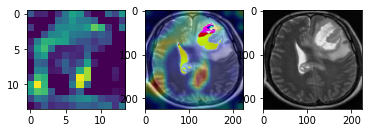

In [205]:
image, heatmap, superimposed_img = model.grad_cam(X_train[0])
plot_gradcam(image, heatmap, superimposed_img)

In [206]:
import seaborn as sns

def crcm(model, x, y, p=True):
    y_pred = model.predict(x)
    y_pred = np.asarray(y_pred)
    y_pred = np.uint8(y_pred+0.5)
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)
    if p:
        plt.xlabel('Pred')
        sns.heatmap(cm, vmin=0, annot=True)
        print(cr)
    cr = classification_report(y, y_pred, output_dict=True )
    return cm, cr

              precision    recall  f1-score   support

           0       0.57      0.17      0.26        24
           1       0.43      0.83      0.57        18

    accuracy                           0.45        42
   macro avg       0.50      0.50      0.41        42
weighted avg       0.51      0.45      0.39        42



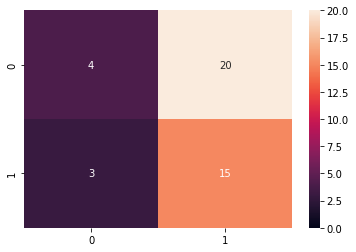

In [207]:
cm_, cr_ = crcm(model, X_val, y_val)

Train with wandb

In [208]:
model.get_model()

In [209]:
import pandas as pd
df = pd.DataFrame
cr_list = []
cm_list = []
# callbacks = [earlystopper]
# callbacks = [model_checkpoint_callback]
callbacks = []
for i in range(5):
    model.get_model()
    # Train
    # model.train(callbacks=callbacks, verbose=2, wb=True)

    model.transfer_learning(callbacks=callbacks, verbose=2, wb=True)

    # model.model.summary()
    cm_, cr_ = crcm(model, X_val, y_val, p=False)
    cm_list.append(cm_)
    cr_['pos'] = {'precision': i,
  'recall': i,
  'f1-score': i,
  'support': i}
    if i > 0:
        df = df.append(pd.DataFrame.from_dict(cr_))
    else:
        df = pd.DataFrame.from_dict(cr_)
df.mean(level=0)

Epoch 1/50
625/625 - 24s - loss: 0.3611 - accuracy: 0.8620 - val_loss: 0.5009 - val_accuracy: 0.7619 - 24s/epoch - 38ms/step
Epoch 2/50
625/625 - 22s - loss: 0.2257 - accuracy: 0.9132 - val_loss: 0.5383 - val_accuracy: 0.7619 - 22s/epoch - 35ms/step
Epoch 3/50
625/625 - 22s - loss: 0.1893 - accuracy: 0.9396 - val_loss: 0.2377 - val_accuracy: 0.8333 - 22s/epoch - 36ms/step
Epoch 4/50
625/625 - 22s - loss: 0.1589 - accuracy: 0.9552 - val_loss: 0.6554 - val_accuracy: 0.8333 - 22s/epoch - 36ms/step
Epoch 5/50
625/625 - 22s - loss: 0.1178 - accuracy: 0.9628 - val_loss: 0.6377 - val_accuracy: 0.8333 - 22s/epoch - 35ms/step
Epoch 6/50
625/625 - 22s - loss: 0.1232 - accuracy: 0.9616 - val_loss: 0.8026 - val_accuracy: 0.8571 - 22s/epoch - 35ms/step
Epoch 7/50
625/625 - 22s - loss: 0.1177 - accuracy: 0.9756 - val_loss: 0.4518 - val_accuracy: 0.8571 - 22s/epoch - 35ms/step
Epoch 8/50
625/625 - 22s - loss: 0.0963 - accuracy: 0.9776 - val_loss: 1.1308 - val_accuracy: 0.8095 - 22s/epoch - 35ms/step


C:\Users\big_j\AppData\Local\Temp/ipykernel_14956/1429203944.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict(cr_))


Epoch 1/50
625/625 - 23s - loss: 0.3444 - accuracy: 0.8620 - val_loss: 0.3715 - val_accuracy: 0.8333 - 23s/epoch - 37ms/step
Epoch 2/50
625/625 - 21s - loss: 0.2255 - accuracy: 0.9176 - val_loss: 0.2341 - val_accuracy: 0.9048 - 21s/epoch - 34ms/step
Epoch 3/50
625/625 - 22s - loss: 0.1931 - accuracy: 0.9368 - val_loss: 0.3510 - val_accuracy: 0.9048 - 22s/epoch - 35ms/step
Epoch 4/50
625/625 - 21s - loss: 0.1634 - accuracy: 0.9472 - val_loss: 0.3532 - val_accuracy: 0.8810 - 21s/epoch - 34ms/step
Epoch 5/50
625/625 - 22s - loss: 0.1463 - accuracy: 0.9600 - val_loss: 0.5990 - val_accuracy: 0.9048 - 22s/epoch - 35ms/step
Epoch 6/50
625/625 - 21s - loss: 0.1199 - accuracy: 0.9652 - val_loss: 0.9926 - val_accuracy: 0.8333 - 21s/epoch - 34ms/step
Epoch 7/50
625/625 - 22s - loss: 0.1079 - accuracy: 0.9736 - val_loss: 0.8234 - val_accuracy: 0.8571 - 22s/epoch - 34ms/step
Epoch 8/50
625/625 - 22s - loss: 0.1112 - accuracy: 0.9736 - val_loss: 0.5447 - val_accuracy: 0.8571 - 22s/epoch - 34ms/step


C:\Users\big_j\AppData\Local\Temp/ipykernel_14956/1429203944.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict(cr_))


Epoch 1/50
625/625 - 23s - loss: 0.3495 - accuracy: 0.8560 - val_loss: 1.8530 - val_accuracy: 0.4286 - 23s/epoch - 37ms/step
Epoch 2/50
625/625 - 21s - loss: 0.2465 - accuracy: 0.9104 - val_loss: 1.0057 - val_accuracy: 0.7143 - 21s/epoch - 34ms/step
Epoch 3/50
625/625 - 22s - loss: 0.1866 - accuracy: 0.9340 - val_loss: 0.5500 - val_accuracy: 0.8333 - 22s/epoch - 35ms/step
Epoch 4/50
625/625 - 22s - loss: 0.1389 - accuracy: 0.9516 - val_loss: 1.9449 - val_accuracy: 0.7619 - 22s/epoch - 35ms/step
Epoch 5/50
625/625 - 22s - loss: 0.1353 - accuracy: 0.9632 - val_loss: 0.6885 - val_accuracy: 0.8095 - 22s/epoch - 35ms/step
Epoch 6/50
625/625 - 22s - loss: 0.1425 - accuracy: 0.9632 - val_loss: 0.4251 - val_accuracy: 0.8095 - 22s/epoch - 35ms/step
Epoch 7/50
625/625 - 22s - loss: 0.1109 - accuracy: 0.9708 - val_loss: 0.4210 - val_accuracy: 0.9048 - 22s/epoch - 35ms/step
Epoch 8/50
625/625 - 22s - loss: 0.0943 - accuracy: 0.9724 - val_loss: 1.0605 - val_accuracy: 0.8333 - 22s/epoch - 35ms/step


C:\Users\big_j\AppData\Local\Temp/ipykernel_14956/1429203944.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict(cr_))


Epoch 1/50
625/625 - 23s - loss: 0.3618 - accuracy: 0.8488 - val_loss: 0.9780 - val_accuracy: 0.6429 - 23s/epoch - 37ms/step
Epoch 2/50
625/625 - 22s - loss: 0.2319 - accuracy: 0.9124 - val_loss: 0.3906 - val_accuracy: 0.8333 - 22s/epoch - 35ms/step
Epoch 3/50
625/625 - 22s - loss: 0.1784 - accuracy: 0.9380 - val_loss: 0.3520 - val_accuracy: 0.7857 - 22s/epoch - 35ms/step
Epoch 4/50
625/625 - 22s - loss: 0.1479 - accuracy: 0.9520 - val_loss: 0.7548 - val_accuracy: 0.8095 - 22s/epoch - 35ms/step
Epoch 5/50
625/625 - 22s - loss: 0.1314 - accuracy: 0.9588 - val_loss: 0.9143 - val_accuracy: 0.8333 - 22s/epoch - 35ms/step
Epoch 6/50
625/625 - 22s - loss: 0.1219 - accuracy: 0.9668 - val_loss: 0.8177 - val_accuracy: 0.8095 - 22s/epoch - 35ms/step
Epoch 7/50
625/625 - 22s - loss: 0.1140 - accuracy: 0.9704 - val_loss: 0.5651 - val_accuracy: 0.8333 - 22s/epoch - 35ms/step
Epoch 8/50
625/625 - 22s - loss: 0.0938 - accuracy: 0.9732 - val_loss: 1.6586 - val_accuracy: 0.8571 - 22s/epoch - 35ms/step


C:\Users\big_j\AppData\Local\Temp/ipykernel_14956/1429203944.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict(cr_))
C:\Users\big_j\AppData\Local\Temp/ipykernel_14956/1429203944.py:26: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df.mean(level=0)


,0,1,accuracy,macro avg,weighted avg,pos
precision,0.906522,0.849123,0.880952,0.877822,0.881922,2.0
recall,0.883333,0.877778,0.880952,0.880556,0.880952,2.0
f1-score,0.894681,0.863063,0.880952,0.878872,0.881130,2.0
support,24.000000,18.000000,0.880952,42.000000,42.000000,2.0


In [210]:
cr_list = []
cm_list = []
# callbacks = [earlystopper]
# callbacks = [model_checkpoint_callback]
callbacks = []
for i in range(5):
    model.get_model()
    opt = tf.keras.optimizers.RMSprop(learning_rate=configs['fine_tune_learning_rate'])
    model.model.compile(optimizer=opt,
                loss=configs['loss_fn'],
                metrics=configs['metrics'])
    # Train

    model.fine_tune(callbacks=callbacks, verbose=2, wb=True)

    # model.model.summary()
    cm_, cr_ = crcm(model, X_val, y_val, p=False)
    cm_list.append(cm_)
    cr_['pos'] = {'precision': i,
  'recall': i,
  'f1-score': i,
  'support': i}
    if i > 0:
        df = df.append(pd.DataFrame.from_dict(cr_))
    else:
        df = pd.DataFrame.from_dict(cr_)
df.mean(level=0)

Epoch 1/10
625/625 - 22s - loss: 0.7162 - accuracy: 0.6412 - val_loss: 0.5899 - val_accuracy: 0.5714 - 22s/epoch - 35ms/step
Epoch 2/10
625/625 - 21s - loss: 0.5492 - accuracy: 0.7388 - val_loss: 0.5267 - val_accuracy: 0.7857 - 21s/epoch - 33ms/step
Epoch 3/10
625/625 - 21s - loss: 0.4654 - accuracy: 0.7956 - val_loss: 0.5710 - val_accuracy: 0.7381 - 21s/epoch - 33ms/step
Epoch 4/10
625/625 - 21s - loss: 0.4245 - accuracy: 0.8120 - val_loss: 0.5457 - val_accuracy: 0.7857 - 21s/epoch - 33ms/step
Epoch 5/10
625/625 - 21s - loss: 0.3944 - accuracy: 0.8268 - val_loss: 0.5481 - val_accuracy: 0.7857 - 21s/epoch - 33ms/step
Epoch 6/10
625/625 - 21s - loss: 0.3676 - accuracy: 0.8424 - val_loss: 0.5057 - val_accuracy: 0.7857 - 21s/epoch - 33ms/step
Epoch 7/10
625/625 - 21s - loss: 0.3497 - accuracy: 0.8532 - val_loss: 0.4756 - val_accuracy: 0.7619 - 21s/epoch - 34ms/step
Epoch 8/10
625/625 - 21s - loss: 0.3235 - accuracy: 0.8656 - val_loss: 0.5172 - val_accuracy: 0.8095 - 21s/epoch - 33ms/step


C:\Users\big_j\AppData\Local\Temp/ipykernel_14956/3308023365.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict(cr_))


Epoch 1/10
625/625 - 23s - loss: 0.7072 - accuracy: 0.5916 - val_loss: 0.6821 - val_accuracy: 0.5476 - 23s/epoch - 36ms/step
Epoch 2/10
625/625 - 21s - loss: 0.5027 - accuracy: 0.7652 - val_loss: 0.6589 - val_accuracy: 0.5714 - 21s/epoch - 34ms/step
Epoch 3/10
625/625 - 23s - loss: 0.4544 - accuracy: 0.7892 - val_loss: 0.6143 - val_accuracy: 0.6190 - 23s/epoch - 37ms/step
Epoch 4/10
625/625 - 22s - loss: 0.4206 - accuracy: 0.8120 - val_loss: 0.5984 - val_accuracy: 0.6429 - 22s/epoch - 36ms/step
Epoch 5/10
625/625 - 22s - loss: 0.3976 - accuracy: 0.8260 - val_loss: 0.5299 - val_accuracy: 0.7381 - 22s/epoch - 36ms/step
Epoch 6/10
625/625 - 22s - loss: 0.3743 - accuracy: 0.8404 - val_loss: 0.4889 - val_accuracy: 0.8095 - 22s/epoch - 36ms/step
Epoch 7/10
625/625 - 22s - loss: 0.3449 - accuracy: 0.8548 - val_loss: 0.4617 - val_accuracy: 0.7857 - 22s/epoch - 35ms/step
Epoch 8/10
625/625 - 22s - loss: 0.3367 - accuracy: 0.8652 - val_loss: 0.4570 - val_accuracy: 0.8095 - 22s/epoch - 35ms/step


C:\Users\big_j\AppData\Local\Temp/ipykernel_14956/3308023365.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict(cr_))


Epoch 1/10
625/625 - 24s - loss: 0.6643 - accuracy: 0.6956 - val_loss: 0.8170 - val_accuracy: 0.5238 - 24s/epoch - 38ms/step
Epoch 2/10
625/625 - 22s - loss: 0.5458 - accuracy: 0.7240 - val_loss: 0.7738 - val_accuracy: 0.5714 - 22s/epoch - 36ms/step
Epoch 3/10
625/625 - 23s - loss: 0.4835 - accuracy: 0.7760 - val_loss: 0.7210 - val_accuracy: 0.5952 - 23s/epoch - 36ms/step
Epoch 4/10
625/625 - 23s - loss: 0.4355 - accuracy: 0.8020 - val_loss: 0.6900 - val_accuracy: 0.5952 - 23s/epoch - 37ms/step
Epoch 5/10
625/625 - 23s - loss: 0.4012 - accuracy: 0.8248 - val_loss: 0.6950 - val_accuracy: 0.6190 - 23s/epoch - 37ms/step
Epoch 6/10
625/625 - 23s - loss: 0.3801 - accuracy: 0.8340 - val_loss: 0.6276 - val_accuracy: 0.6429 - 23s/epoch - 36ms/step
Epoch 7/10
625/625 - 23s - loss: 0.3493 - accuracy: 0.8524 - val_loss: 0.6787 - val_accuracy: 0.6429 - 23s/epoch - 36ms/step
Epoch 8/10
625/625 - 23s - loss: 0.3358 - accuracy: 0.8536 - val_loss: 0.6749 - val_accuracy: 0.6667 - 23s/epoch - 36ms/step


C:\Users\big_j\AppData\Local\Temp/ipykernel_14956/3308023365.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict(cr_))


Epoch 1/10
625/625 - 24s - loss: 0.7258 - accuracy: 0.7024 - val_loss: 0.7966 - val_accuracy: 0.4762 - 24s/epoch - 39ms/step
Epoch 2/10
625/625 - 23s - loss: 0.5289 - accuracy: 0.7596 - val_loss: 0.7728 - val_accuracy: 0.5476 - 23s/epoch - 37ms/step
Epoch 3/10
625/625 - 24s - loss: 0.4855 - accuracy: 0.7816 - val_loss: 0.6835 - val_accuracy: 0.5952 - 24s/epoch - 38ms/step
Epoch 4/10
625/625 - 26s - loss: 0.4320 - accuracy: 0.8188 - val_loss: 0.6781 - val_accuracy: 0.6429 - 26s/epoch - 41ms/step
Epoch 5/10
625/625 - 24s - loss: 0.4047 - accuracy: 0.8248 - val_loss: 0.6319 - val_accuracy: 0.6667 - 24s/epoch - 38ms/step
Epoch 6/10
625/625 - 24s - loss: 0.3632 - accuracy: 0.8540 - val_loss: 0.6391 - val_accuracy: 0.6905 - 24s/epoch - 38ms/step
Epoch 7/10
625/625 - 23s - loss: 0.3556 - accuracy: 0.8568 - val_loss: 0.6020 - val_accuracy: 0.7143 - 23s/epoch - 37ms/step
Epoch 8/10
625/625 - 23s - loss: 0.3253 - accuracy: 0.8648 - val_loss: 0.5566 - val_accuracy: 0.7381 - 23s/epoch - 37ms/step


C:\Users\big_j\AppData\Local\Temp/ipykernel_14956/3308023365.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict(cr_))
C:\Users\big_j\AppData\Local\Temp/ipykernel_14956/3308023365.py:27: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df.mean(level=0)


,0,1,accuracy,macro avg,weighted avg,pos
precision,0.964376,0.667223,0.77619,0.815799,0.837025,2.0
recall,0.633333,0.966667,0.77619,0.800000,0.776190,2.0
f1-score,0.761516,0.788296,0.77619,0.774906,0.772993,2.0
support,24.000000,18.000000,0.77619,42.000000,42.000000,2.0


In [211]:
if RunningInCOLAB:
  from google.colab import drive
  drive.mount('/content/drive/')

  !cp '{model_filename}' "/content/drive/MyDrive/model"